In [2]:
import numpy as np
import pandas as pd
import pickle

## DESIGN FUNCTIONS
# Electrochemical module

In [7]:
2**32

4294967296

In [3]:

def cost_function(L, delta, epsilon, A_cell, c_cat, rho_cat):
    """
    Cost Function
    -------------

    Returns:
    - cost ($) : Catalyst cost for the entire cell area
      C = rho_cat * delta * (1 - epsilon) * A_cell * c_cat
    """
    return rho_cat * delta * (1 - epsilon) * A_cell * c_cat


def eta_activation(j, j0, S_cat, epsilon, delta, a, b):
    """
    Activation Overpotential (Tafel form)
    -------------------------------------
    η_act = a + b * log( j / j0_geo )
    where j0_geo = j0 * S_cat * (1 - epsilon) * delta

    Returns:
    - η_act (V)
    """
    # Exchange current density per geometric area
    j0_geo = j0 * S_cat * (1 - epsilon) * delta

    # Avoid taking log of non-positive numbers
    if j0_geo <= 0 or j <= 0:
        return 1e6  # large penalty

    return a + b * np.log(j / j0_geo)


def eta_concentration(j, R, T, n, F, C_bulk, D, epsilon, tau, delta):
    """
    Concentration Overpotential
    ---------------------------
    η_conc = (R*T/(n*F)) * ln(1 - j/j_lim)
    Returns:
    - η_conc (V)
    Deff: Effective diffusivity (m²/s)
    D: Bulk diffusivity of the species in the bulk fluid (m²/s). This is the diffusivity in the absence of any porous medium.
    τ: Tortuosity of the catalyst layer (dimensionless). This accounts for the complex, winding paths that molecules must take through the porous structure.
    """
    # from Brugemman's equation #relate Tortuosity to porosity 
    # (https://www.engineeringtoolbox.com/tortuosity-d_1019.html)
    tau = epsilon**0.5
        
    D_eff = (epsilon / tau) * D  # effective diffusivity (cm^2/s)
    # limiting current density (A/cm^2)

    
    j_lim = (n * F * D_eff * C_bulk) / delta

    # check validity
    if j_lim <= j or j_lim <= 0 or j <= 0:
        return 1e6  # large penalty or infeasible

    # RT/(nF) ~ typical factor in log term
    factor = (R * T) / (n * F)
    
    

    return factor * np.log(1.0 - j / j_lim)


def eta_total(
    j,        # (A/cm^2) current density (geometric)
    j0,       # (A/cm^2_active) exchange current density (per active area)
    S_cat,    # (cm^2_active/cm^3 or cm^2_active/g) specific surface area
    epsilon,  # (dimensionless) porosity
    delta,    # (cm) layer thickness
    a, b,     # Tafel coefficients for activation: a (V), b (V)
    R, T,     # R (J/(mol*K)), T (K)
    n, F,     # n (dimensionless), F (C/mol)
    C_bulk,   # (mol/cm^3) bulk reactant concentration
    D,        # (cm^2/s) diffusivity
    tau       # (dimensionless) tortuosity
):
    
    act = eta_activation(j, j0, S_cat, epsilon, delta, a, b)
    conc = eta_concentration(j, R, T, n, F, C_bulk, D, epsilon, tau, delta)
    return act + conc

##### INITIALIZATION VARIABLES AND CONSTANTS

In [4]:
# "Operating & Constraint Parameters"

A_cell = 50.0 # ("Cell Active Area (cm²)", value=)
j = 2 # ("Operating Current Density j (A/cm²)",
R=8.314
T=  353 #("Temperature (K)", value=353.0)
alpha = 0.5 # ("alpha", value=)
n_e   = 2 # ("n (electrons)", value=2)
F_const = 96485.0 #couloumbs

C_bulk_a =0.01 #  ("Anode Bulk Conc (mol/cm³)", )
D_a      = 1e-2 # ("Anode Diffusivity (cm²/s)", )
tau_a    =  1.2 # ("Anode Tortuosity", value=) ---------------------bruggeman's equalation

C_bulk_c = 0.01 # "Cathode Bulk Conc (mol/cm³)")
D_c      = 1e-2 # ("Cathode Diffusivity (cm²/s)", )
tau_c    = 1.2 # ("Cathode Tortuosity",  ) -------------------------Use the Brudgeman's equation

eta_max = 2 # ("Max Overpotential (V)", value=2.0)

# Catalyst: Anode
rho_cat_a =  11.66 # ("Anode Catalyst Density (g/cm³)", value=11.66)
c_cat_a   =  100 #("Anode Catalyst Cost ($/g)", value=100.0)
j0_a      =  1e-3 #("Anode j0 (A/cm²_active)", value=1e-3)
a_a       =  0.1 #("Anode Tafel a (V)", value=0.1)
b_a       =  0.05 #("Anode Tafel b (V)", value=0.05)

# Catalyst: Cathode
rho_cat_c =  21.45 #("Cathode Catalyst Density (g/cm³)", value=21.45)
c_cat_c   =  60.0 #("Cathode Catalyst Cost ($/g)", value=60.0)
j0_c      =  1e-3 #("Cathode j0 (A/cm²_active)", value=1e-3)
a_c       =  0.08 #("Cathode Tafel a (V)", value=0.08)
b_c       =  0.04 #("Cathode Tafel b (V)", value=0.04)


In [5]:
###############################################################################
# 4) Constraint Sliders
###############################################################################
# "Constraint Bounds"

eps_a_min, eps_a_max = (0.01,0.99)#  ("Anode Porosity Range", 0.0,1.0,(0.01,0.99))
eps_c_min, eps_c_max = (0.01,0.99)# ("Cathode Porosity Range",0.0,1.0,(0.01,0.99))

delta_a_min, delta_a_max = (1e-4,0.01) # ("Anode Thickness δ_a (cm)", 1e-4,0.05,(1e-4,0.01))
delta_c_min, delta_c_max =  (1e-4,0.01) #("Cathode Thickness δ_c (cm)",1e-4,0.05,(1e-4,0.01))

Scat_a_min, Scat_a_max = (1e3,1e5) # ("Anode S_cat Range", 1e2,1e6,(1e3,1e5))
Scat_c_min, Scat_c_max = (1e3,1e5) # ("Cathode S_cat Range",1e2,1e6,(1e3,1e5))

L_a_min, L_a_max = (0.001,0.02) # ("Anode Catalyst Loading L_a",0.0,0.05,(0.001,0.02))
L_c_min, L_c_max = (0.001,0.02) # ("Cathode Catalyst Loading L_c",0.0,0.05,(0.001,0.02))

tau_a_min, tau_a_max = (1.0,3.0) # ("Anode Tortuosity Range",0.5,5.0,(1.0,3.0))
tau_c_min, tau_c_max = (1.0,3.0) # ("Cathode Tortuosity Range",0.5,5.0,(1.0,3.0))

SA_a_min = 100 # ("Anode Min Effective Surface (cm²)", value=100.0)
SA_c_min =  100 # ("Cathode Min Effective Surface (cm²)", value=100.0)

j_min, j_max = (0.0,0.1) # ("Operating Current Density j Range",0.0,1.0,(0.0,0.1))





- visualizing the design space

In [ ]:
# visualizing design space
#x1, x2, x3 = (eps_a, delta_a, Scat_a)
x1, x2, x3 = np.meshgrid(np.linspace(eps_a_min, eps_a_max, 100), np.linspace(delta_a_min, delta_a_max, 100), np.linspace(Scat_a_min, Scat_a_max, 100))

f1 =cost_function(L_a, delta_a, eps_a, Acell, Ccat_a, rho_cat_a)
f2 =eta_total(j, j0_a, S_cat_a, epsilon=eps_a, delta=delta_a, rho_cat=rho_cat_a, Acell=Acell, Ccat=Ccat_a)

#constraints    
# Constraint calculations
g1 = 0.001 - epsilon_a
g2 = epsilon_a - 0.999
g3 = 0.001 - epsilon_c
g4 = epsilon_c - 0.999
g5 = 1e-6 - delta_a
g6 = delta_a - 50e-6
g7 = 1e-6 - delta_c
g8 = delta_c - 50e-6
g9 = 20 - Scat_a
g10 = Scat_a - 100
g11 = 50 - Scat_c
g12 = Scat_c - 200
g13 = self.SA_min_a - Scat_a * (1 - epsilon_a) * delta_a*1e4 #Convert delta to cm
g14 = self.SA_min_c - Scat_c * (1 - epsilon_c) * delta_c*1e4 #Convert delta to cm
g15 = self.j_min - j
g16 = j - self.j_max
g17 = eta_total - self.eta_max
g18 = self.L_a_min - (self.rho_cat_a * delta_a * (1 - epsilon_a))
g19 = (self.rho_cat_a * delta_a * (1 - epsilon_a)) - self.L_a_max
g20 = self.L_c_min - (self.rho_cat_c * delta_c * (1 - epsilon_c))
g21 = (self.rho_cat_c * delta_c * (1 - epsilon_c)) - self.L_c_max



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plots (if needed)

# Problem parameters (Example values - REPLACE WITH YOURS)
Acell = 100  # cm^2
rho_cat_a = 11.7e6  # g/m^3
rho_cat_c = 21.45e6  # g/m^3
Ccat_a = 200  # $/g
Ccat_c = 50  # $/g
j = 1  # A/cm^2 (Fixed for visualization)
T = 353 #K (80 C)
n = 2
F = 96485 #C/mol
R = 8.314 #J/mol.K
D = 2e-9 #m^2/s
j0_a = 1e-4 #A/cm2
j0_c = 1e-3 #A/cm2
a_a = 0.1
b_a = 0.03
a_c = 0.05
b_c = 0.025
SA_min_a = 1000 # cm2/cm3
SA_min_c = 1000 # cm2/cm3
L_a_min = 1e-4 # g/cm^2
L_a_max = 1e-3 # g/cm^2
L_c_min = 1e-4 # g/cm^2
L_c_max = 1e-3 # g/cm^2
eta_max = 0.4

# Define the objective functions (cost and total overpotential)
def cost(delta_a, epsilon_a, delta_c, epsilon_c):
    return (rho_cat_a * delta_a * (1 - epsilon_a) + rho_cat_c * delta_c * (1 - epsilon_c)) * Acell * (Ccat_a+Ccat_c)

def eta_total_func(delta_a, epsilon_a, Scat_a, delta_c, epsilon_c, Scat_c):
    tau_a = epsilon_a**(-1.5)
    tau_c = epsilon_c**(-1.5)
    D_eff_a = (epsilon_a/tau_a) * D
    D_eff_c = (epsilon_c/tau_c) * D
    eta_act_a = a_a + b_a * np.log10(j / (j0_a * Scat_a * (1 - epsilon_a) * delta_a*1e4))
    eta_act_c = a_c + b_c * np.log10(j / (j0_c * Scat_c * (1 - epsilon_c) * delta_c*1e4))
    eta_conc_a = (R * T / (n * F)) * np.log(1 - j/((n*F*D_eff_a*55.5)/(delta_a*1e4)))
    eta_conc_c = (R * T / (n * F)) * np.log(1 - j/((n*F*D_eff_c*55.5)/(delta_c*1e4)))
    return eta_act_a + eta_act_c + eta_conc_a + eta_conc_c

# Define the constraints (in the form g(x) <= 0)
def constraints(delta_a, epsilon_a, Scat_a, delta_c, epsilon_c, Scat_c):
    g1 = 0.001 - epsilon_a
    g2 = epsilon_a - 0.999
    g3 = 0.001 - epsilon_c
    g4 = epsilon_c - 0.999
    g5 = 1e-6 - delta_a
    g6 = delta_a - 50e-6
    g7 = 1e-6 - delta_c
    g8 = delta_c - 50e-6
    g9 = 20 - Scat_a
    g10 = Scat_a - 100
    g11 = 50 - Scat_c
    g12 = Scat_c - 200
    g13 = SA_min_a - Scat_a * (1 - epsilon_a) * delta_a*1e4
    g14 = SA_min_c - Scat_c * (1 - epsilon_c) * delta_c*1e4
    g15 = j_min - j
    g16 = j - j_max
    g17 = eta_total_func(delta_a, epsilon_a, Scat_a, delta_c, epsilon_c, Scat_c) - eta_max
    g18 = L_a_min - (rho_cat_a * delta_a * (1 - epsilon_a))
    g19 = (rho_cat_a * delta_a * (1 - epsilon_a)) - L_a_max
    g20 = L_c_min - (rho_cat_c * delta_c * (1 - epsilon_c))
    g21 = (rho_cat_c * delta_c * (1 - epsilon_c)) - L_c_max
    return [g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, g11, g12, g13, g14, g15, g16, g17,g18,g19,g20,g21]

# Create the design space (example: varying delta_a and epsilon_a)
delta_a_vals = np.linspace(1e-6, 50e-6, 50)
epsilon_a_vals = np.linspace(0.001, 0.999, 50)
delta_c_vals = np.linspace(1e-6, 50e-6, 50)
epsilon_c_vals = np.linspace(0.001, 0.999, 50)
Scat_a_vals = np.linspace(20, 100, 50)
Scat_c_vals = np.linspace(50, 200, 50)

Delta_a, Epsilon_a = np.meshgrid(delta_a_vals, epsilon_a_vals)
Delta_c, Epsilon_c = np.meshgrid(delta_c_vals, epsilon_c_vals)
Scat_A, Scat_C = np.meshgrid(Scat_a_vals, Scat_c_vals)


# Calculate objective function values
Cost = cost(Delta_a, Epsilon_a, 25e-6, 0.5) #Fixing delta_c and epsilon_c for 2D plot
Eta_total = eta_total_func(Delta_a, Epsilon_a, 50, 25e-6, 0.5, 100) #Fixing delta_c, epsilon_c, and Scat_c for 2D plot

# Calculate constraint values (example)
g1_vals = constraints(Delta_a, Epsilon_a, 50, 25e-6, 0.5, 100)[0] #Fixing delta_c, epsilon_c, and Scat_c for 2D plot


# Plotting
plt.figure(figsize=(10, 8))

# Contour plots
contour_cost = plt.contour(Delta_a*1e6, Epsilon_a, Cost, levels=20, colors='blue', linestyles='solid', label = "Cost") #Scale delta to micro meter
contour_eta = plt.contour(Delta_a*1e6, Epsilon_a, Eta_total, levels=20, colors='red', linestyles='dashed', label = "Eta Total") #Scale delta to micro meter

plt.clabel(contour_cost, inline=True, fontsize=8)
plt.clabel(contour_eta, inline=True, fontsize=8)

# Constraint plots (example)
plt.contour(Delta_a*1e6, Epsilon_a, g1_vals, levels=[0], colors='green', linewidths=2) #Scale delta to micro meter

# Pareto set (this needs to be calculated by an optimization algorithm)
# Example Pareto set (replace with actual results from your optimization)
#pare

C:\Users\derne\AppData\Local\Temp\ipykernel_22624\4058075358.py:42: RuntimeWarning: invalid value encountered in log
  eta_conc_a = (R * T / (n * F)) * np.log(1 - j/((n*F*D_eff_a*55.5)/(delta_a*1e4)))
C:\Users\derne\AppData\Local\Temp\ipykernel_22624\4058075358.py:43: RuntimeWarning: invalid value encountered in log
  eta_conc_c = (R * T / (n * F)) * np.log(1 - j/((n*F*D_eff_c*55.5)/(delta_c*1e4)))


NameError: name 'j_min' is not defined

C:\Users\derne\AppData\Local\Temp\ipykernel_53112\4156898278.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  CS1 = plt.contour( X1, X2, F1, 10 * levels, colors='black', alpha=0.5, label="$f_1(x)$")
C:\Users\derne\AppData\Local\Temp\ipykernel_53112\4156898278.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  CS2 = plt.contour(X1, X2, F2, levels, linestyles="dashed", colors='black', alpha=0.5, label="$f_2(x)$")


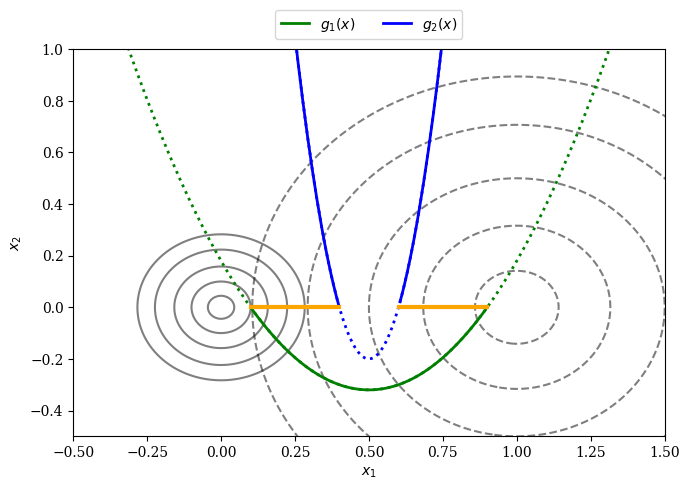

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
# Define the contour levels
levels = np.array([0.02, 0.1, 0.25, 0.5, 0.8])

plt.figure(figsize=(7, 5))
# Plot the contours of the objective functions: F1
CS1 = plt.contour( X1, X2, F1, 10 * levels, colors='black', alpha=0.5, label="$f_1(x)$")

# plot the contours of the objective functions: for the second objective 2
CS2 = plt.contour(X1, X2, F2, levels, linestyles="dashed", colors='black', alpha=0.5, label="$f_2(x)$")


# Plot the objective functions
plt.plot(X1[0], G1, linewidth=2.0, color="green", linestyle='dotted')
plt.plot(X1[0][G1<0], G1[G1<0], label="$g_1(x)$", linewidth=2.0, color="green")

plt.plot(X1[0], G2, linewidth=2.0, color="blue", linestyle='dotted')
plt.plot(X1[0][X1[0]>0.6], G2[X1[0]>0.6], label="$g_2(x)$",linewidth=2.0, color="blue")
plt.plot(X1[0][X1[0]<0.4], G2[X1[0]<0.4], linewidth=2.0, color="blue")

plt.plot(np.linspace(0.1,0.4,100), np.zeros(100),linewidth=3.0, color="orange")
plt.plot(np.linspace(0.6,0.9,100), np.zeros(100),linewidth=3.0, color="orange")

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12),
          ncol=4, fancybox=True, shadow=False)

plt.tight_layout()
plt.show()

C:\Users\derne\AppData\Local\Temp\ipykernel_53112\4156898278.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  CS1 = plt.contour( X1, X2, F1, 10 * levels, colors='black', alpha=0.5, label="$f_1(x)$")
C:\Users\derne\AppData\Local\Temp\ipykernel_53112\4156898278.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  CS2 = plt.contour(X1, X2, F2, levels, linestyles="dashed", colors='black', alpha=0.5, label="$f_2(x)$")


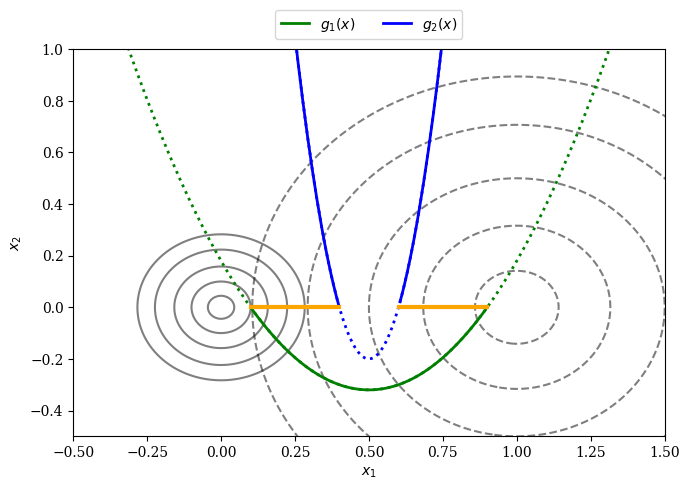

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
# Define the contour levels
levels = np.array([0.02, 0.1, 0.25, 0.5, 0.8])

plt.figure(figsize=(7, 5))
# Plot the contours of the objective functions: F1
CS1 = plt.contour( X1, X2, F1, 10 * levels, colors='black', alpha=0.5, label="$f_1(x)$")

# plot the contours of the objective functions: for the second objective 2
CS2 = plt.contour(X1, X2, F2, levels, linestyles="dashed", colors='black', alpha=0.5, label="$f_2(x)$")


# Plot the objective functions
plt.plot(X1[0], G1, linewidth=2.0, color="green", linestyle='dotted')
plt.plot(X1[0][G1<0], G1[G1<0], label="$g_1(x)$", linewidth=2.0, color="green")

plt.plot(X1[0], G2, linewidth=2.0, color="blue", linestyle='dotted')
plt.plot(X1[0][X1[0]>0.6], G2[X1[0]>0.6], label="$g_2(x)$",linewidth=2.0, color="blue")
plt.plot(X1[0][X1[0]<0.4], G2[X1[0]<0.4], linewidth=2.0, color="blue")

plt.plot(np.linspace(0.1,0.4,100), np.zeros(100),linewidth=3.0, color="orange")
plt.plot(np.linspace(0.6,0.9,100), np.zeros(100),linewidth=3.0, color="orange")

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12),
          ncol=4, fancybox=True, shadow=False)

plt.tight_layout()
plt.show()

C:\Users\derne\AppData\Local\Temp\ipykernel_53112\4156898278.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  CS1 = plt.contour( X1, X2, F1, 10 * levels, colors='black', alpha=0.5, label="$f_1(x)$")
C:\Users\derne\AppData\Local\Temp\ipykernel_53112\4156898278.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  CS2 = plt.contour(X1, X2, F2, levels, linestyles="dashed", colors='black', alpha=0.5, label="$f_2(x)$")


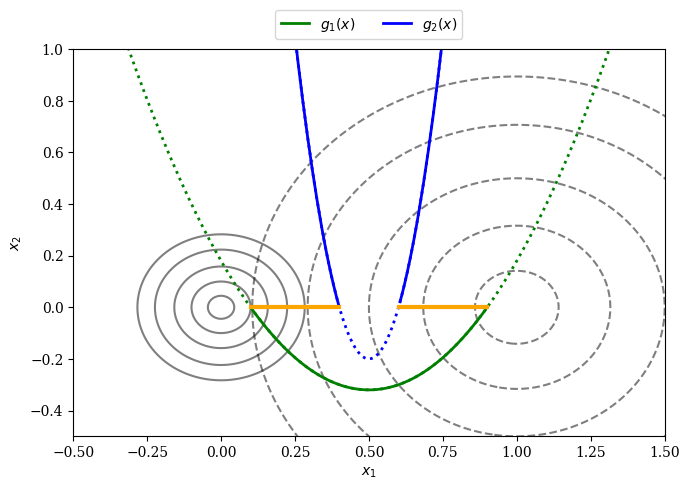

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
# Define the contour levels
levels = np.array([0.02, 0.1, 0.25, 0.5, 0.8])

plt.figure(figsize=(7, 5))
# Plot the contours of the objective functions: F1
CS1 = plt.contour( X1, X2, F1, 10 * levels, colors='black', alpha=0.5, label="$f_1(x)$")

# plot the contours of the objective functions: for the second objective 2
CS2 = plt.contour(X1, X2, F2, levels, linestyles="dashed", colors='black', alpha=0.5, label="$f_2(x)$")


# Plot the objective functions
plt.plot(X1[0], G1, linewidth=2.0, color="green", linestyle='dotted')
plt.plot(X1[0][G1<0], G1[G1<0], label="$g_1(x)$", linewidth=2.0, color="green")

plt.plot(X1[0], G2, linewidth=2.0, color="blue", linestyle='dotted')
plt.plot(X1[0][X1[0]>0.6], G2[X1[0]>0.6], label="$g_2(x)$",linewidth=2.0, color="blue")
plt.plot(X1[0][X1[0]<0.4], G2[X1[0]<0.4], linewidth=2.0, color="blue")

plt.plot(np.linspace(0.1,0.4,100), np.zeros(100),linewidth=3.0, color="orange")
plt.plot(np.linspace(0.6,0.9,100), np.zeros(100),linewidth=3.0, color="orange")

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12),
          ncol=4, fancybox=True, shadow=False)

plt.tight_layout()
plt.show()

C:\Users\derne\AppData\Local\Temp\ipykernel_53112\4156898278.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  CS1 = plt.contour( X1, X2, F1, 10 * levels, colors='black', alpha=0.5, label="$f_1(x)$")
C:\Users\derne\AppData\Local\Temp\ipykernel_53112\4156898278.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  CS2 = plt.contour(X1, X2, F2, levels, linestyles="dashed", colors='black', alpha=0.5, label="$f_2(x)$")


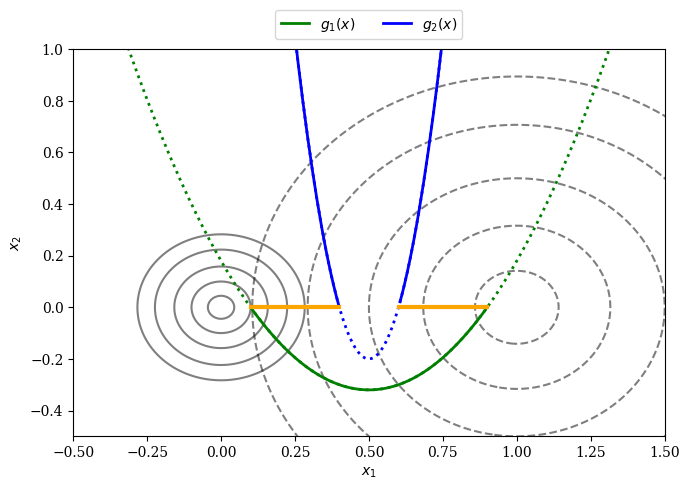

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
# Define the contour levels
levels = np.array([0.02, 0.1, 0.25, 0.5, 0.8])

plt.figure(figsize=(7, 5))
# Plot the contours of the objective functions: F1
CS1 = plt.contour( X1, X2, F1, 10 * levels, colors='black', alpha=0.5, label="$f_1(x)$")

# plot the contours of the objective functions: for the second objective 2
CS2 = plt.contour(X1, X2, F2, levels, linestyles="dashed", colors='black', alpha=0.5, label="$f_2(x)$")


# Plot the objective functions
plt.plot(X1[0], G1, linewidth=2.0, color="green", linestyle='dotted')
plt.plot(X1[0][G1<0], G1[G1<0], label="$g_1(x)$", linewidth=2.0, color="green")

plt.plot(X1[0], G2, linewidth=2.0, color="blue", linestyle='dotted')
plt.plot(X1[0][X1[0]>0.6], G2[X1[0]>0.6], label="$g_2(x)$",linewidth=2.0, color="blue")
plt.plot(X1[0][X1[0]<0.4], G2[X1[0]<0.4], linewidth=2.0, color="blue")

plt.plot(np.linspace(0.1,0.4,100), np.zeros(100),linewidth=3.0, color="orange")
plt.plot(np.linspace(0.6,0.9,100), np.zeros(100),linewidth=3.0, color="orange")

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12),
          ncol=4, fancybox=True, shadow=False)

plt.tight_layout()
plt.show()

C:\Users\derne\AppData\Local\Temp\ipykernel_53112\4156898278.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  CS1 = plt.contour( X1, X2, F1, 10 * levels, colors='black', alpha=0.5, label="$f_1(x)$")
C:\Users\derne\AppData\Local\Temp\ipykernel_53112\4156898278.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  CS2 = plt.contour(X1, X2, F2, levels, linestyles="dashed", colors='black', alpha=0.5, label="$f_2(x)$")


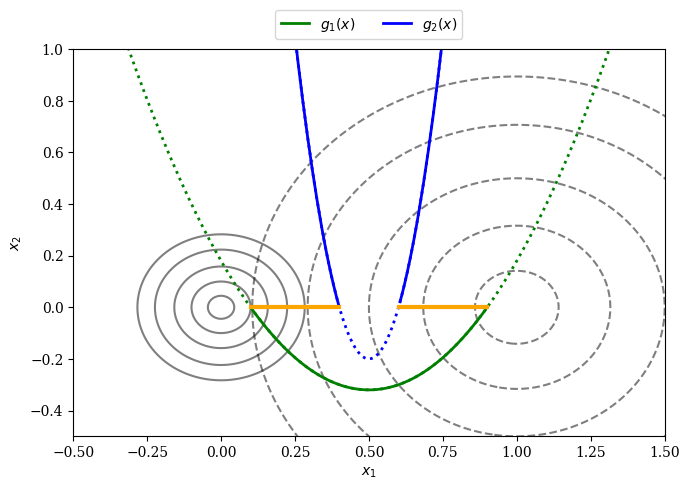

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
# Define the contour levels
levels = np.array([0.02, 0.1, 0.25, 0.5, 0.8])

plt.figure(figsize=(7, 5))
# Plot the contours of the objective functions: F1
CS1 = plt.contour( X1, X2, F1, 10 * levels, colors='black', alpha=0.5, label="$f_1(x)$")

# plot the contours of the objective functions: for the second objective 2
CS2 = plt.contour(X1, X2, F2, levels, linestyles="dashed", colors='black', alpha=0.5, label="$f_2(x)$")


# Plot the objective functions
plt.plot(X1[0], G1, linewidth=2.0, color="green", linestyle='dotted')
plt.plot(X1[0][G1<0], G1[G1<0], label="$g_1(x)$", linewidth=2.0, color="green")

plt.plot(X1[0], G2, linewidth=2.0, color="blue", linestyle='dotted')
plt.plot(X1[0][X1[0]>0.6], G2[X1[0]>0.6], label="$g_2(x)$",linewidth=2.0, color="blue")
plt.plot(X1[0][X1[0]<0.4], G2[X1[0]<0.4], linewidth=2.0, color="blue")

plt.plot(np.linspace(0.1,0.4,100), np.zeros(100),linewidth=3.0, color="orange")
plt.plot(np.linspace(0.6,0.9,100), np.zeros(100),linewidth=3.0, color="orange")

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12),
          ncol=4, fancybox=True, shadow=False)

plt.tight_layout()
plt.show()

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Problem parameters (Example values - REPLACE WITH YOURS)
Acell = 100  # cm^2
rho_cat_a = 11.7e6  # g/m^3
rho_cat_c = 21.45e6  # g/m^3
Ccat_a = 200  # $/g
Ccat_c = 50  # $/g
j = 1  # A/cm^2 (Fixed for visualization)
T = 353 #K (80 C)
n = 2
F = 96485 #C/mol
R = 8.314 #J/mol.K
D = 2e-9 #m^2/s
j0_a = 1e-4 #A/cm2
j0_c = 1e-3 #A/cm2
a_a = 0.1
b_a = 0.03
a_c = 0.05
b_c = 0.025
SA_min_a = 1000 # cm2/cm3
SA_min_c = 1000 # cm2/cm3
L_a_min = 1e-4 # g/cm^2
L_a_max = 1e-3 # g/cm^2
L_c_min = 1e-4 # g/cm^2
L_c_max = 1e-3 # g/cm^2
eta_max = 0.4
delta_c_fixed = 25e-6
epsilon_c_fixed = 0.5
Scat_c_fixed = 100

# Define the objective functions
def cost(delta_a, epsilon_a):
    return (rho_cat_a * delta_a * (1 - epsilon_a) + rho_cat_c * delta_c_fixed * (1 - epsilon_c_fixed)) * Acell * (Ccat_a+Ccat_c)

def eta_total_func(delta_a, epsilon_a, Scat_a):
    tau_a = epsilon_a**(-1.5)
    D_eff_a = (epsilon_a/tau_a) * D
    eta_act_a = a_a + b_a * np.log10(j / (j0_a * Scat_a * (1 - epsilon_a) * delta_a*1e4))
    eta_act_c = a_c + b_c * np.log10(j / (j0_c * Scat_c_fixed * (1 - epsilon_c_fixed) * delta_c_fixed*1e4))
    eta_conc_a = (R * T / (n * F)) * np.log(1 - j/((n*F*D_eff_a*55.5)/(delta_a*1e4)))
    eta_conc_c = (R * T / (n * F)) * np.log(1 - j/((n*F*(epsilon_c_fixed/epsilon_c_fixed**(-1.5))*D*55.5)/(delta_c_fixed*1e4)))
    return eta_act_a + eta_act_c + eta_conc_a + eta_conc_c

# Define the constraints (in the form g(x) <= 0)
def constraints(delta_a, epsilon_a, Scat_a):
    g1 = 0.001 - epsilon_a
    g2 = epsilon_a - 0.999
    g5 = 1e-6 - delta_a
    g6 = delta_a - 50e-6
    g9 = 20 - Scat_a
    g10 = Scat_a - 100
    g13 = SA_min_a - Scat_a * (1 - epsilon_a) * delta_a*1e4
    g15 = - j #j_min - j = -j since j is fixed
    g16 = j - 2 #j - j_max = j-2 because jmax is 2
    g17 = eta_total_func(delta_a, epsilon_a, Scat_a) - eta_max
    g18 = L_a_min - (rho_cat_a * delta_a * (1 - epsilon_a))
    g19 = (rho_cat_a * delta_a * (1 - epsilon_a)) - L_a_max
    return [g1, g2, g5, g6, g9, g10, g13, g15, g16, g17,g18,g19]

# Create the design space
num_points = 50
delta_a_vals = np.linspace(1e-6, 50e-6, num_points)
epsilon_a_vals = np.linspace(0.001, 0.999, num_points)
Scat_a_vals = np.linspace(20, 100, num_points)

Delta_a, Epsilon_a = np.meshgrid(delta_a_vals, epsilon_a_vals)

# Calculate objective function values (fixing Scat_a for 2D plot)
Cost = cost(Delta_a, Epsilon_a)
Eta_total = eta_total_func(Delta_a, Epsilon_a, 50)  # Fixed Scat_a = 50

# Calculate constraint values
G = np.array([constraints(Delta_a, Epsilon_a, scat) for scat in Scat_a_vals])

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Contour plots
contour_cost = ax.contour(Delta_a*1e6, Epsilon_a, Cost, levels=np.linspace(Cost.min(), Cost.max(), 10), colors='blue', linestyles='solid', label="Cost")
contour_eta = ax.contour(Delta_a*1e6, Epsilon_a, Eta_total, levels=np.linspace(Eta_total.min(), Eta_total.max(), 10), colors='red', linestyles='dashed', label="Eta Total")

ax.clabel(contour_cost, inline=True, fontsize=8, fmt='%1.2f') # Formatted labels
ax.clabel(contour_eta, inline=True, fontsize=8, fmt='%1.2f') # Formatted labels

# Constraint plots
constraint_labels = ["ε_a min", "ε_a max", "δ_a min", "δ_a max", "Scat_a min", "Scat_a max", "SA_min_a", "j min", "j max", "η_total max","L_a min","L_a max"]
constraint_colors = ['green', 'green', 'orange', 'orange', 'purple', 'purple', 'brown', 'grey','grey','cyan','magenta','magenta']

for i in range(G.shape[2]):  # Iterate through each constraint
    constraint_values = G[0, :, :, i] # using the first Scat_a value to plot the constraints in 2D
    contour = ax.contour(Delta_a*1e6, Epsilon_a, constraint_values, levels=[0], colors=constraint_colors[i], linewidths=2, label=constraint_labels[i])
    # manually add the label to the legend
    contour.collections[0].set_label(constraint_labels[i])

ax.set_xlabel("Delta_a (µm)")
ax.set_ylabel("Epsilon_a")
ax.set_title("Objective Functions and Constraints")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)
plt.tight_layout()
plt.show()

C:\Users\derne\AppData\Local\Temp\ipykernel_24464\343955202.py:42: RuntimeWarning: invalid value encountered in log
  eta_conc_a = (R * T / (n * F)) * np.log(1 - j/((n*F*D_eff_a*55.5)/(delta_a*1e4)))
C:\Users\derne\AppData\Local\Temp\ipykernel_24464\343955202.py:43: RuntimeWarning: invalid value encountered in log
  eta_conc_c = (R * T / (n * F)) * np.log(1 - j/((n*F*(epsilon_c_fixed/epsilon_c_fixed**(-1.5))*D*55.5)/(delta_c_fixed*1e4)))


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (50, 12) + inhomogeneous part.

## PROBLEM DEFINITION

----

In [5]:
# problem definition
# import problem modules
from pymoo.core.problem import (
                        Problem,           # Vectorized - since most MO algorithms work with populations, this class evaluates a set of solutons at once 
                        ElementwiseProblem # Inherits from the Problem Class, works with a single solution at a time
                               )
from pymoo.problems.functional import FunctionalProblem  # Inherits from the ElementwiseProblem class , works with functions for each objective and constraint




In [ ]:
class PemProblem(ElementwiseProblem):
    def __init__(self,
                  eps_a_min, eps_a_max,eps_c_min, eps_c_max,
                 delta_a_min, delta_a_max,delta_c_min, delta_c_max,
                 Scat_a_min, Scat_a_max,Scat_c_min, Scat_c_max,
                 L_a_min, L_a_max,L_c_min, L_c_max,
                 SA_a_min, SA_c_min,
                 j_min, j_max,
                #  tau_a_min, tau_a_max,tau_c_min, tau_c_max,
                
                , *args, **kwargs):
        super().__init__(n_var=6, 
                         n_obj=2, 
                         n_constr=24, 
                         xl=[delta_a_min, eps_a_min, Scat_a_min, delta_c_min, eps_c_min, Scat_c_min], 
                         xu=[delta_a_max, eps_a_max, Scat_a_max, delta_c_max, eps_c_max, Scat_c_max]
                         )
        
        # store attributes
        # Bounds
        self.eps_a_min = eps_a_min
        self.eps_a_max = eps_a_max
        self.eps_c_min = eps_c_min
        self.eps_c_max = eps_c_max

        self.delta_a_min = delta_a_min
        self.delta_a_max = delta_a_max
        self.delta_c_min = delta_c_min
        self.delta_c_max = delta_c_max

        self.Scat_a_min = Scat_a_min
        self.Scat_a_max = Scat_a_max
        self.Scat_c_min = Scat_c_min
        self.Scat_c_max = Scat_c_max

        self.L_a_min = L_a_min
        self.L_a_max = L_a_max
        self.L_c_min = L_c_min
        self.L_c_max = L_c_max

        self.SA_a_min = SA_a_min
        self.SA_c_min = SA_c_min
        #no we didn't add an upper bound,

        self.j_min = j_min
        self.j_max = j_max
        
        
        
    def _evaluate(self, x, out, *args, **kwargs):
        
        #objective fuctions
        obj1 = cost_function()
        obj2 = eta_total()
    
        #stacking objectives to F and contrainsts to G
        out['F'] = np.column_stack([obj1, obj2])
        
        #constraints
        # Build the 24 constraints => G <= 0 => feasible
        # omitted for brevity, but should yield exactly 24 constraints
        g_list = []

        # 1) Porosity: 4
        g_list += [-ε_a, ε_a - 1, -ε_c, ε_c - 1]
        # 2) Thickness: 4
        g_list += [self.delta_a_min - δ_a, δ_a - self.delta_a_max,
                   self.delta_c_min - δ_c, δ_c - self.delta_c_max]
        # 3) S_cat: 4
        g_list += [self.Scat_a_min - S_a, S_a - self.Scat_a_max,
                   self.Scat_c_min - S_c, S_c - self.Scat_c_max]
        # 4) Catalyst Loading: 4
        g_list += [self.L_a_min - L_a, L_a - self.L_a_max,
                   self.L_c_min - L_c, L_c - self.L_c_max]

        # 5) Effective Surface: 2
        eff_a = S_a * (1-ε_a)*δ_a
        eff_c = S_c * (1-ε_c)*δ_c
        g_list += [self.SA_a_min - eff_a, self.SA_c_min - eff_c]
        # 7) Current Den: 2
        g_list += [self.j_min - self.j, self.j - self.j_max]
        # 8) Overpotential: 1
        g_list += [eta_cell - self.eta_max]

        out["G"] = g_list

        
    
    

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
algorithm = NSGA2(pop_size = 200)

In [ ]:
import numpy as np
from pymoo.core.problem import Problem

class CatalystLayerProblem(Problem):
    def __init__(self, delta_a_min, delta_a_max, ..., L_c_max): # Include all your bounds and parameters
        
        
        super().__init__(n_var=6, 
                         n_obj=2, 
                         n_ieq_constr=21, 
                         xl=np.array([0.001, delta_a_min, Scat_a_min, 0.001, delta_c_min, Scat_c_min]), 
                         xu=np.array([0.999, delta_a_max, Scat_a_max, 0.999, delta_c_max, Scat_c_max]), 
                         type_var=np.double
                         )
        self.delta_a_min = delta_a_min
        # ... store all your parameters

    def _evaluate(self, x, out, *args, **kwargs):
        delta_a, epsilon_a, Scat_a, delta_c, epsilon_c, Scat_c = x.T

        # Calculate objectives (cost and total overpotential)
        cost = ... # Your cost function calculation
        eta_total = ... # Your total overpotential calculation

        # Calculate constraint violations (g1 to g21)
        g1 = 0.001 - epsilon_a
        g2 = epsilon_a - 0.999
        # ... (calculate all g functions)

        out["F"] = np.column_stack([cost, eta_total])
        out["G"] = np.column_stack([g1, g2, ..., g21])

# Example usage:
problem = CatalystLayerProblem(delta_a_min=1e-6, delta_a_max=5e-5, ..., L_c_max=...) # Initialize with your values

In [ ]:
import numpy as np
import pyomo.environ as pyo
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination import get_termination
from pymoo.optimize import minimize

class PEMElectrolyzerProblem(Problem):
    def __init__(self, Acell, rho_cat_a, rho_cat_c, Ccat_a, Ccat_c, j_min, j_max, eta_max, SA_min_a, SA_min_c, L_a_min, L_a_max, L_c_min, L_c_max, T, n, F, R, D):
        super().__init__(n_var=6, n_obj=2, n_ieq_constr=21, xl=np.array([0.001, 1e-6, 20, 0.001, 1e-6, 50]), xu=np.array([0.999, 50e-6, 100, 0.999, 50e-6, 200]), type_var=np.double) #Corrected bounds
        self.Acell = Acell
        self.rho_cat_a = rho_cat_a
        self.rho_cat_c = rho_cat_c
        self.Ccat_a = Ccat_a
        self.Ccat_c = Ccat_c
        self.j_min = j_min
        self.j_max = j_max
        self.eta_max = eta_max
        self.SA_min_a = SA_min_a
        self.SA_min_c = SA_min_c
        self.L_a_min = L_a_min
        self.L_a_max = L_a_max
        self.L_c_min = L_c_min
        self.L_c_max = L_c_max
        self.T = T
        self.n = n
        self.F = F
        self.R = R
        self.D = D

    def _evaluate(self, x, out, *args, **kwargs):
        delta_a, epsilon_a, Scat_a, delta_c, epsilon_c, Scat_c = x.T

        # Tortuosity Calculations
        tau_a = epsilon_a**(-1.5)
        tau_c = epsilon_c**(-1.5)

        #Effective Diffusivity Calculations
        D_eff_a = (epsilon_a/tau_a) * self.D
        D_eff_c = (epsilon_c/tau_c) * self.D

        # Exchange current densities (Example values, needs to be replaced)
        j0_a = 1e-4 #A/cm2
        j0_c = 1e-3 #A/cm2

        # Tafel coefficients (Example values, needs to be replaced)
        a_a = 0.1
        b_a = 0.03
        a_c = 0.05
        b_c = 0.025

        # Current density (A/cm^2)
        j = 1 # Example value, you might want to consider it a parameter or vary it

        # Overpotential calculations (using example values for Tafel parameters)
        eta_act_a = a_a + b_a * np.log10(j / (j0_a * Scat_a * (1 - epsilon_a) * delta_a*1e4)) #Convert delta to cm
        eta_act_c = a_c + b_c * np.log10(j / (j0_c * Scat_c * (1 - epsilon_c) * delta_c*1e4)) #Convert delta to cm

        eta_conc_a = (self.R * self.T / (self.n * self.F)) * np.log(1 - j/((self.n*self.F*D_eff_a*55.5)/(delta_a*1e4))) #Convert delta to cm and water concentration to mol/cm3
        eta_conc_c = (self.R * self.T / (self.n * self.F)) * np.log(1 - j/((self.n*self.F*D_eff_c*55.5)/(delta_c*1e4))) #Convert delta to cm and water concentration to mol/cm3

        eta_total = eta_act_a + eta_act_c + eta_conc_a + eta_conc_c

        # Cost calculation
        cost = (self.rho_cat_a * delta_a * (1 - epsilon_a) + self.rho_cat_c * delta_c * (1 - epsilon_c)) * self.Acell * (self.Ccat_a+self.Ccat_c)

        # Constraint calculations
        g1 = 0.001 - epsilon_a
        g2 = epsilon_a - 0.999
        g3 = 0.001 - epsilon_c
        g4 = epsilon_c - 0.999
        g5 = 1e-6 - delta_a
        g6 = delta_a - 50e-6
        g7 = 1e-6 - delta_c
        g8 = delta_c - 50e-6
        g9 = 20 - Scat_a
        g10 = Scat_a - 100
        g11 = 50 - Scat_c
        g12 = Scat_c - 200
        g13 = self.SA_min_a - Scat_a * (1 - epsilon_a) * delta_a*1e4 #Convert delta to cm
        g14 = self.SA_min_c - Scat_c * (1 - epsilon_c) * delta_c*1e4 #Convert delta to cm
        g15 = self.j_min - j
        g16 = j - self.j_max
        g17 = eta_total - self.eta_max
        g18 = self.L_a_min - (self.rho_cat_a * delta_a * (1 - epsilon_a))
        g19 = (self.rho_cat_a * delta_a * (1 - epsilon_a)) - self.L_a_max
        g20 = self.L_c_min - (self.rho_cat_c * delta_c * (1 - epsilon_c))
        g21 = (self.rho_cat_c * delta_c * (1 - epsilon_c)) - self.L_c_max

        out["F"] = np.column_stack([cost, eta_total])
        out["G"] = np.column_stack([g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, g11, g12, g13, g14, g15, g16, g17, g18, g19, g20, g21])

# Problem parameters (Example values, needs to be replaced)
Acell = 100  # cm^2
rho_cat_a = 11.7e6  # g/m^3
rho_cat_c = 21.45e6  # g/m^3
Ccat_a = 200  # $/g
Ccat_c = 50  # $/g
j_min = 0.1  # A/cm^2
j_max = 2  # A/cm^2
eta_max = 0.4  # V
SA_min_a = 1000 # cm2/cm3
SA_min_c = 1000 # cm2/cm3
L_a_min = 1e-4 # g/cm^2
L_a_max = 1e-3 # g/cm^2
L_c_min = 1e-4 # g/cm^2
L_c_max = 1e-3 # g/cm^2
T = 353 #K (80 C)
n = 2
F = 96485 #C/mol
R = 8.314 #J/mol.K
D = 2e-9 #m^

In [ ]:
# from utils.models import cost_function, eta_total


###############################################################################
# PEMProblem (Base, 24 constraints)
###############################################################################

class PEMProblem(ElementwiseProblem):
    """
    Base multiobjective problem for an anode + cathode PEM electrolyzer design.
    Decision Variables (6):
      x = [δ_a, ε_a, S_cat_a, δ_c, ε_c, S_cat_c]

    Objectives (2):
      F0 = total cost
      F1 = total overpotential

    Constraints (24 total):
      1) Porosity    => 4
      2) Thickness   => 4
      3) S_cat       => 4  specific surface area
      4) CatalystLoad=> 4
      5) Tortuosity  => 4 # TO BE REMOVED AND REPLACE WITH bruggeman equation τ_a = ε_a⁻¹.⁵, This eliminates four constraints (τ_a_min ≤ τ_a ≤ τ_a_max and τ_c_min ≤ τ_c ≤ τ_c_max) and makes the tortuosity a dependent variable 
      6) SurfaceArea => 2 effective surace area
      7) CurrentDen  => 2
      8) Overpot     => 1
      -------------
      total = 25? Actually 4+4+4+4+4+2+2+1=25. But typically we only do one
      combined. Check carefully. We count: 4 + 4 + 4 + 4 + 4 + 2 + 2 + 1 = 25.
      Possibly the last "overpotential" is 1 => 25. If your base problem
      truly has 24 constraints, confirm your math.

      If you only see 24 in your own list, that is fine. 
      The key is that e-Constraint method can add +1 to the base problem's constraints.
    """
    def __init__(self,
                 A_cell, j, R, T, alpha, n, F,
                 C_bulk_a, D_a, tau_a,
                 C_bulk_c, D_c, tau_c,
                 eta_max,
                 rho_cat_a, c_cat_a, j0_a, a_a, b_a,
                 rho_cat_c, c_cat_c, j0_c, a_c, b_c,
                 eps_a_min, eps_a_max,
                 eps_c_min, eps_c_max,
                 delta_a_min, delta_a_max,
                 delta_c_min, delta_c_max,
                 Scat_a_min, Scat_a_max,
                 Scat_c_min, Scat_c_max,
                 L_a_min, L_a_max,
                 L_c_min, L_c_max,
                 tau_a_min, tau_a_max,
                 tau_c_min, tau_c_max,
                 SA_a_min, SA_c_min,
                 j_min, j_max,
                 # We'll set n_constr=24 to match your base problem assumption
                 n_var=6, n_obj=2, n_constr=24):

        # Decision space: 6D => [δ_a, eps_a, S_cat_a, δ_c, eps_c, S_cat_c]
        # Lower bound => [delta_a_min, eps_a_min, Scat_a_min, delta_c_min, eps_c_min, Scat_c_min]
        # Upper bound => [delta_a_max, eps_a_max, Scat_a_max, delta_c_max, eps_c_max, Scat_c_max]
        super().__init__(
            n_var=n_var,
            n_obj=n_obj,
            n_constr=n_constr,
            xl=[delta_a_min, eps_a_min, Scat_a_min,
                delta_c_min, eps_c_min, Scat_c_min],
            xu=[delta_a_max, eps_a_max, Scat_a_max,
                delta_c_max, eps_c_max, Scat_c_max]
        )

        # Store attributes
        self.A_cell = A_cell
        self.j = j
        self.R = R
        self.T = T
        self.alpha = alpha
        self.n = n
        self.F = F

        # Anode side
        self.C_bulk_a = C_bulk_a
        self.D_a = D_a
        self.tau_a = tau_a

        # Cathode side
        self.C_bulk_c = C_bulk_c
        self.D_c = D_c
        self.tau_c = tau_c

        self.eta_max = eta_max

        # Catalyst props anode
        self.rho_cat_a = rho_cat_a
        self.c_cat_a   = c_cat_a
        self.j0_a      = j0_a
        self.a_a       = a_a
        self.b_a       = b_a

        # Catalyst props cathode
        self.rho_cat_c = rho_cat_c
        self.c_cat_c   = c_cat_c
        self.j0_c      = j0_c
        self.a_c       = a_c
        self.b_c       = b_c

        # Constraints
        self.eps_a_min = eps_a_min
        self.eps_a_max = eps_a_max
        self.eps_c_min = eps_c_min
        self.eps_c_max = eps_c_max

        self.delta_a_min = delta_a_min
        self.delta_a_max = delta_a_max
        self.delta_c_min = delta_c_min
        self.delta_c_max = delta_c_max

        self.Scat_a_min = Scat_a_min
        self.Scat_a_max = Scat_a_max
        self.Scat_c_min = Scat_c_min
        self.Scat_c_max = Scat_c_max

        self.L_a_min = L_a_min
        self.L_a_max = L_a_max
        self.L_c_min = L_c_min
        self.L_c_max = L_c_max

        self.tau_a_min = tau_a_min
        self.tau_a_max = tau_a_max
        self.tau_c_min = tau_c_min
        self.tau_c_max = tau_c_max

        self.SA_a_min = SA_a_min
        self.SA_c_min = SA_c_min

        self.j_min = j_min
        self.j_max = j_max

    def _evaluate(self, x, out, *args, **kwargs):
        δ_a, ε_a, S_a, δ_c, ε_c, S_c = x

        # Cost
        L_a = self.rho_cat_a*δ_a*(1-ε_a)
        L_c = self.rho_cat_c*δ_c*(1-ε_c)
        cost_a = L_a * self.A_cell * self.c_cat_a
        cost_c = L_c * self.A_cell * self.c_cat_c
        cost_total = cost_a + cost_c

        # Overpotential
        # Suppose you have a function: eta_total(...) => returns activation+concentration
        # We'll assume correct.
        eta_a = eta_total(
            j=self.j, j0=self.j0_a, S_cat=S_a, epsilon=ε_a, delta=δ_a,
            a=self.a_a, b=self.b_a, R=self.R, T=self.T, n=self.n, F=self.F,
            C_bulk=self.C_bulk_a, D=self.D_a, tau=self.tau_a
        )
        eta_c = eta_total(
            j=self.j, j0=self.j0_c, S_cat=S_c, epsilon=ε_c, delta=δ_c,
            a=self.a_c, b=self.b_c, R=self.R, T=self.T, n=self.n, F=self.F,
            C_bulk=self.C_bulk_c, D=self.D_c, tau=self.tau_c
        )
        eta_cell = eta_a + eta_c

        out["F"] = [cost_total, eta_cell]

        # Build the 24 constraints => G <= 0 => feasible
        # omitted for brevity, but should yield exactly 24 constraints
        g_list = []

        # 1) Porosity: 4
        g_list += [-ε_a, ε_a - 1, -ε_c, ε_c - 1]
        # 2) Thickness: 4
        g_list += [self.delta_a_min - δ_a, δ_a - self.delta_a_max,
                   self.delta_c_min - δ_c, δ_c - self.delta_c_max]
        # 3) S_cat: 4
        g_list += [self.Scat_a_min - S_a, S_a - self.Scat_a_max,
                   self.Scat_c_min - S_c, S_c - self.Scat_c_max]
        # 4) Catalyst Loading: 4
        g_list += [self.L_a_min - L_a, L_a - self.L_a_max,
                   self.L_c_min - L_c, L_c - self.L_c_max]
        # 5) Tortuosity: 4
        g_list += [self.tau_a_min - self.tau_a, self.tau_a - self.tau_a_max,
                   self.tau_c_min - self.tau_c, self.tau_c - self.tau_c_max]
        # 6) Effective Surface: 2
        eff_a = S_a * (1-ε_a)*δ_a
        eff_c = S_c * (1-ε_c)*δ_c
        g_list += [self.SA_a_min - eff_a, self.SA_c_min - eff_c]
        # 7) Current Den: 2
        g_list += [self.j_min - self.j, self.j - self.j_max]
        # 8) Overpotential: 1
        g_list += [eta_cell - self.eta_max]

        out["G"] = g_list


### ALGORITHMS

In [ ]:
algorithms_list = [de_algo , ga_algo , nm_algo]

import time

for algo in algorithms_list:
    print(f"********  with {type(algo).__name__} Algorithm ********")
    start_time = time.time()
    res = minimize(problem = prob,
                algorithm = algo,
                seed=1,
                verbose=False)
    end_time = time.time()
    
    print("\n")
    print("Solution: \nX = %s\nF = %s" % (res.X, res.F))
    print(f"Time Taken: {end_time - start_time} \n")

In [ ]:

###############################################################################
# Pareto-based
###############################################################################

def multiobjective_optimization(problem, method_name, pop_size=40, n_gen=50):
    if method_name == "NSGA2":
        alg = NSGA2(pop_size=pop_size)
    elif method_name == "MOEA/D":
        alg = MOEAD(pop_size=pop_size, n_neighbors=15, decomposition="pbi")
    elif method_name == "SPEA2":
        alg = SPEA2(pop_size=pop_size)
    else:
        alg = NSGA2(pop_size=pop_size)

    termination = get_termination("n_gen", n_gen)
    return minimize(problem, alg, termination, seed=1, verbose=False)



In [ ]:

###############################################################################
# Scalarization Subclasses
###############################################################################

def weighted_sum_optimization(problem, w1=0.5, w2=0.5):
    class WeightedSumProblem(ElementwiseProblem):
        def __init__(self, base_prob, w1, w2):
            super().__init__(
                n_var=base_prob.n_var,
                n_obj=1,
                n_constr=base_prob.n_constr,  # same # constraints as base
                xl=base_prob.xl,
                xu=base_prob.xu
            )
            self.base = base_prob
            self.w1 = w1
            self.w2 = w2

        def _evaluate(self, x, out, *args, **kwargs):
            out_mo = {}
            self.base._evaluate(x, out_mo, *args, **kwargs)
            cost = out_mo["F"][0]
            eta  = out_mo["F"][1]
            f = self.w1 * cost + self.w2 * eta
            out["F"] = [f]
            out["G"] = out_mo["G"]

    single_obj_problem = WeightedSumProblem(problem, w1, w2)
    algo = GA(pop_size=40)
    term = get_termination("n_gen", 30)
    return minimize(single_obj_problem, algo, term, seed=1, verbose=False)


def e_constraint_optimization(problem, eps_value=1.0):
    class EConstraintProblem(ElementwiseProblem):
        def __init__(self, base_prob, eps):
            super().__init__(
                n_var=base_prob.n_var,
                n_obj=1,
                # +1 constraint
                n_constr=base_prob.n_constr + 1,
                xl=base_prob.xl,
                xu=base_prob.xu
            )
            self.base = base_prob
            self.eps = eps

        def _evaluate(self, x, out, *args, **kwargs):
            out_mo = {}
            self.base._evaluate(x, out_mo, *args, **kwargs)
            cost = out_mo["F"][0]
            eta  = out_mo["F"][1]

            # Append new constraint: eta <= eps => eta - eps <= 0
            G_base = out_mo["G"]
            g_list = list(G_base)  # 24 constraints
            g_list.append(eta - self.eps)  # +1 => 25

            out["F"] = [cost]
            out["G"] = g_list

    single_obj_problem = EConstraintProblem(problem, eps_value)
    algo = GA(pop_size=40)
    term = get_termination("n_gen", 30)
    return minimize(single_obj_problem, algo, term, seed=1, verbose=False)


def goal_seeking_optimization(problem, goals=(10.0, 0.5)):
    class GoalProblem(ElementwiseProblem):
        def __init__(self, base_prob, goals):
            super().__init__(
                n_var=base_prob.n_var,
                n_obj=1,
                n_constr=base_prob.n_constr,
                xl=base_prob.xl,
                xu=base_prob.xu
            )
            self.base = base_prob
            self.cost_goal, self.eta_goal = goals

        def _evaluate(self, x, out, *args, **kwargs):
            out_mo = {}
            self.base._evaluate(x, out_mo, *args, **kwargs)
            cost = out_mo["F"][0]
            eta  = out_mo["F"][1]

            # single objective => sum of squared deviations
            f = (cost - self.cost_goal)**2 + (eta - self.eta_goal)**2
            out["F"] = [f]
            out["G"] = out_mo["G"]

    single_obj_problem = GoalProblem(problem, goals)
    algo = GA(pop_size=40)
    term = get_termination("n_gen", 30)
    return minimize(single_obj_problem, algo, term, seed=1, verbose=False)


In [ ]:

###############################################################################
# Master run_optimization
###############################################################################

def run_optimization(category, method, **kwargs):
    """
    Creates a new PEMProblem with 24 constraints each run,
    Then calls either scalarization or Pareto-based approach.

    - If scalarization => WeightedSum, eConstraint, or GoalSeeking
      => no pop_size, n_gen is used
    - If Pareto-based => NSGA2, MOEA/D, SPEA2
      => pop_size, n_gen is used

    'scalar_params' can be passed in kwargs but is popped out here.
    """
    scalar_params = kwargs.pop("scalar_params", {})

    if category == "Pareto-based":
        pop_size = kwargs.pop("pop_size", 40)
        n_gen    = kwargs.pop("n_gen", 30)
    else:
        pop_size = None
        n_gen    = None

    # Build fresh base problem => n_constr=24
    base_problem = PEMProblem(**kwargs)

    if category == "Scalarization":
        if method == "Weighted Sum":
            w1 = scalar_params.get("w1", 0.5)
            w2 = scalar_params.get("w2", 0.5)
            return weighted_sum_optimization(base_problem, w1, w2)
        elif method == "ε-Constraint":
            eps_v = scalar_params.get("eps_value", 1.0)
            return e_constraint_optimization(base_problem, eps_v)
        elif method == "Goal Seeking":
            goals = scalar_params.get("goals", (10.0, 0.5))
            return goal_seeking_optimization(base_problem, goals)
        else:
            raise ValueError(f"Unknown scalarization method: {method}")
    else:
        # Pareto-based => pop_size, n_gen
        return multiobjective_optimization(base_problem, method, pop_size, n_gen)
